In [1]:
import gc
import inspect
import PIL
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

from PIL import Image

from diffusers import (
    ControlNetModel,
    StableDiffusionControlNetPipeline,
    DDIMScheduler
)

from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from diffusers.image_processor import PipelineImageInput, VaeImageProcessor
from diffusers.callbacks import MultiPipelineCallbacks, PipelineCallback
from diffusers.utils.torch_utils import is_compiled_module, is_torch_version, randn_tensor
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion import retrieve_timesteps

# Dependencies

The code was tested with following libraries
 - torch==2.4.0 
 - diffusers==0.30.1
 - transformers==4.45.2
 - numpy==2.0.2
 - pillow==10.4.0

In [2]:
def print_images(pil_imgs, with_density=False, points=200, titles=None, s=10):
    fig = plt.figure(figsize=(20, 10))
    n = len(pil_imgs)
    azim = 236 #np.random.uniform(0,360)
    nrows = 2 if with_density else 1
    for i in range(n):
        img = pil_imgs[i]
        ax = fig.add_subplot(nrows, n, i+1)
        ax.imshow(img)
        if titles is not None:
            ax.set_title(titles[i])
        ax.axis('off')
        
        if with_density:
            img = img.convert('RGB')
            w, h = img.size
            arr = np.array(img).reshape(w*h, 3) / 255
            idx = np.random.permutation(w*h)[:points]
            
            ax = fig.add_subplot(nrows, n, n+i+1, projection='3d')
            r = arr[idx, 0]
            g = arr[idx, 1]
            b = arr[idx, 2]
            ax.scatter(r, g, b, c=arr[idx, :], alpha=0.5, s=s)
            ax.view_init(elev=30, azim=azim)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_zlim(0, 1)
            ax.axes.get_xaxis().set_ticklabels([])
            ax.axes.get_yaxis().set_ticklabels([])
            ax.axes.get_zaxis().set_ticklabels([])
    return fig


def decode_to_image(latent_aux, vae):
    with torch.no_grad():
        image = vae.decode(1 / 0.18215 * latent_aux).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    images =  Image.fromarray(images[0])
    gc.collect()
    torch.cuda.empty_cache()
    return images


def rand_rotation_matrix(deflection=1.0, randnums=None):
    """
    Creates a random rotation matrix.
    
    deflection: the magnitude of the rotation. For 0, no rotation; for 1, competely random
    rotation. Small deflection => small perturbation.
    randnums: 3 random numbers in the range [0, 1]. If `None`, they will be auto-generated.
    """
    # from http://www.realtimerendering.com/resources/GraphicsGems/gemsiii/rand_rotation.c
    
    if randnums is None:
        randnums = np.random.uniform(size=(3,))
        
    theta, phi, z = randnums
    
    theta = theta * 2.0*deflection*np.pi  # Rotation about the pole (Z).
    phi = phi * 2.0*np.pi  # For direction of pole deflection.
    z = z * 2.0*deflection  # For magnitude of pole deflection.
    
    # Compute a vector V used for distributing points over the sphere
    # via the reflection I - V Transpose(V).  This formulation of V
    # will guarantee that if x[1] and x[2] are uniformly distributed,
    # the reflected points will be uniform on the sphere.  Note that V
    # has length sqrt(2) to eliminate the 2 in the Householder matrix.
    
    r = np.sqrt(z)
    Vx, Vy, Vz = V = (
        np.sin(phi) * r,
        np.cos(phi) * r,
        np.sqrt(2.0 - z)
        )
    
    st = np.sin(theta)
    ct = np.cos(theta)
    R = np.array(((ct, st, 0), (-st, ct, 0), (0, 0, 1)))
    
    # Construct the rotation matrix  ( V Transpose(V) - I ) R.
    M = (np.outer(V, V) - np.eye(3)).dot(R)
    return M


def sigmoid(x):
    return 1 - 1 / (1 + torch.exp(-35*x))


def get_cdf(x_samples, full_range):
    return sigmoid((x_samples[:,None]-full_range[None,:])).sum(0)/len(x_samples)  


def sliced_wasserstein(loss, pixels_gen, pixels_ref, num_slices=10, use_differenatable_historgam_matching=False):
        for slice_idx in range(num_slices):
            R_trans = rand_rotation_matrix(deflection=1.0)
            R_trans = torch.Tensor(R_trans)
            R_trans = R_trans.to(device).to(torch.bfloat16)
            pixels_gen_rotated = pixels_gen.T@R_trans
            pixels_ref_rotated = pixels_ref.T@R_trans
            for dim_idx in range(3):
                x_samples_3d_rotated_slice = pixels_gen_rotated[:,dim_idx]
                y_samples_3d_rotated_slice = pixels_ref_rotated[:,dim_idx]

                if not use_differenatable_historgam_matching:
                    rand_idxes_len = min(len(x_samples_3d_rotated_slice), len(y_samples_3d_rotated_slice))
                    rand_idxes = np.random.randint(0, rand_idxes_len, rand_idxes_len)
                    x_samples_3d_rotated_slice = x_samples_3d_rotated_slice[rand_idxes]
                    y_samples_3d_rotated_slice = y_samples_3d_rotated_slice[rand_idxes]

                    x_samples_3d_rotated_slice = torch.sort(x_samples_3d_rotated_slice).values
                    y_samples_3d_rotated_slice = torch.sort(y_samples_3d_rotated_slice).values
                    loss += torch.mean(torch.abs(x_samples_3d_rotated_slice-y_samples_3d_rotated_slice))
                else:
                    min_range = min(
                        x_samples_3d_rotated_slice.min().item(),
                        y_samples_3d_rotated_slice.min().item()
                    )
                    max_range = max(
                        x_samples_3d_rotated_slice.max().item(),
                        y_samples_3d_rotated_slice.max().item()
                    )
                    grid_size = 400
                    full_range = torch.linspace(min_range-0.05, max_range+0.05, grid_size)
                    full_range = full_range.to(device)
                    x_cdf = get_cdf(x_samples_3d_rotated_slice, full_range)
                    y_cdf = get_cdf(y_samples_3d_rotated_slice, full_range)
                    loss += torch.mean(torch.abs(x_cdf-y_cdf))
        return loss / num_slices

# SW-Guidance Pipeline with ControlNet

Extended pipeline that includes an additional optimization step ``do_sw_guidance`` and new arguments
    
    sw_reference (PIL.Image): a color reference, if not provided cancels SW-Guidance optimization
    sw_steps (int): number of inner optimization steps refered as M in the paper
    sw_u_lr (float): learning rate for SW optimization
    num_guided_steps (int): number of inference steps where SW guidance is triggered
    sw_num_slices (int): number of slices (projections) for sliced_wasserstein function
    sw_debug (bool): prints intermediate images during inference

The reference image for this pipeline will be resized to resolution 512×512. When reference image is provided, the pipeline offloads VAE and text encoders into cpu. Nvidia RTX 4090 (24GB VRAM) is sufficient to run the pipeline and generate 512×512 images.

In [3]:
class SwControlNetPipeline(StableDiffusionControlNetPipeline):

    def sw_decode(self, latents):
        latents = latents / self.vae.config.scaling_factor
        image = self.vae.decode(latents, return_dict=True).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1)
        image = image.to(torch.float16).numpy()
        image = (image * 255).round().astype("uint8")
        pil_image = Image.fromarray(image[0])
        return pil_image

    def do_sw_guidance(self, sw_steps, sw_u_lr, latents, t, prompt_embeds, added_cond_kwargs, pixels_ref, num_slices=10):
        prompt_embeds = prompt_embeds[1].unsqueeze(0)
        # added_cond_kwargs['time_ids'] = added_cond_kwargs['time_ids'][1].unsqueeze(0)
        # added_cond_kwargs['text_embeds'] = added_cond_kwargs['text_embeds'][1].unsqueeze(0)
        
        u = torch.zeros_like(latents, requires_grad=True, dtype=torch.bfloat16)
        if self.sw_debug:
            print(f"t {t}, prompt_embeds {prompt_embeds.shape}, {prompt_embeds.dtype} grad: {prompt_embeds.requires_grad}")
            print(f"latents: {latents.shape}, {latents.dtype} grad: {latents.requires_grad}")
            # print(f"added_cond_kwargs: {added_cond_kwargs['text_embeds'].shape}, {added_cond_kwargs['text_embeds'].dtype}")
        for tt in range(sw_steps):
            u = u.detach()
            u.requires_grad = True
            x_hat_t = latents.detach() + u
            noise_pred = self.unet(
                x_hat_t, 
                t, 
                encoder_hidden_states=prompt_embeds, 
                cross_attention_kwargs=self.cross_attention_kwargs,
                added_cond_kwargs=added_cond_kwargs,
            ).sample
            sch_step = self.scheduler.step(noise_pred, t, x_hat_t)
            x_0 = sch_step.pred_original_sample.to(torch.bfloat16)
            # x_0 = x_hat_t
            # ------------ Compute loss
            image = self.vae.decode(x_0 / self.vae.config.scaling_factor).sample
            image = (image / 2 + 0.5).clamp(0, 1)
            pixels_gen = image.squeeze(0).reshape(3,-1)
            indx = np.random.randint(0, len(pixels_gen.T), 10_000)
            gen_mean = torch.mean(pixels_gen[:,indx], dim=1)
            ref_mean = torch.mean(pixels_ref[:,indx], dim=1).to(device)
            gen_cov = torch.cov(pixels_gen[:,indx])
            ref_cov = torch.cov(pixels_ref[:,indx]).to(device)

            loss = 0
            # loss = torch.mean(torch.abs(gen_mean - ref_mean)) + torch.mean(torch.abs(gen_cov - ref_cov)) 
            loss = sliced_wasserstein(loss, pixels_gen, pixels_ref)
            if self.sw_debug:
                print(f"tt{tt}  loss ", loss)
            u_t_grad = torch.autograd.grad(loss, u)[0]
            if self.sw_debug:
                print(f"tt{tt}  u_t_grad.std() ", u_t_grad.std())
            with torch.no_grad():
                u_t_grad = u_t_grad #/ u_t_grad.std()
                u.data = u.data - sw_u_lr * u_t_grad
            if self.sw_debug and (t % 2) and (tt == 0):
                pil_image = self.sw_decode(x_0)
                print_images([pil_image, self.ref_im], with_density=True)
                plt.show()
        with torch.no_grad():        
            latents = latents.detach() + u.detach()
        del noise_pred, sch_step, 
        del x_0, image, pixels_gen, 
        del gen_cov, ref_cov
        del loss, u_t_grad, gen_mean, ref_mean, 
        gc.collect()
        torch.cuda.empty_cache()
        return latents
        
      
    def __call__(
        self,
        sw_reference: PIL.Image = None,
        sw_steps: int = 8,
        sw_u_lr: float = 0.013 * 10**4,
        num_guided_steps: int = None,
        sw_num_slices: int = 10, 
        sw_debug: bool = False,
        # ----------------------------------
        prompt: Union[str, List[str]] = None,
        image: PipelineImageInput = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        timesteps: List[int] = None,
        guidance_scale: float = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        ip_adapter_image: Optional[PipelineImageInput] = None,
        ip_adapter_image_embeds: Optional[List[torch.FloatTensor]] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        controlnet_conditioning_scale: Union[float, List[float]] = 1.0,
        guess_mode: bool = False,
        control_guidance_start: Union[float, List[float]] = 0.0,
        control_guidance_end: Union[float, List[float]] = 1.0,
        clip_skip: Optional[int] = None,
        callback_on_step_end: Optional[Callable[[int, int, Dict], None]] = None,
        callback_on_step_end_tensor_inputs: List[str] = ["latents"],
        **kwargs,
    ):
        with torch.no_grad():
            callback = kwargs.pop("callback", None)
            callback_steps = kwargs.pop("callback_steps", None)
    
            if callback is not None:
                deprecate(
                    "callback",
                    "1.0.0",
                    "Passing `callback` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`",
                )
            if callback_steps is not None:
                deprecate(
                    "callback_steps",
                    "1.0.0",
                    "Passing `callback_steps` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`",
                )

            controlnet = self.controlnet._orig_mod if is_compiled_module(self.controlnet) else self.controlnet
    
            # align format for control guidance
            if not isinstance(control_guidance_start, list) and isinstance(control_guidance_end, list):
                control_guidance_start = len(control_guidance_end) * [control_guidance_start]
            elif not isinstance(control_guidance_end, list) and isinstance(control_guidance_start, list):
                control_guidance_end = len(control_guidance_start) * [control_guidance_end]

            # 1. Check inputs. Raise error if not correct
            self.check_inputs(
                prompt,
                image,
                callback_steps,
                negative_prompt,
                prompt_embeds,
                negative_prompt_embeds,
                ip_adapter_image,
                ip_adapter_image_embeds,
                controlnet_conditioning_scale,
                control_guidance_start,
                control_guidance_end,
                callback_on_step_end_tensor_inputs,
            )
            self._guidance_scale = guidance_scale
            self._clip_skip = clip_skip
            self._cross_attention_kwargs = cross_attention_kwargs

            # 2. Define call parameters
            batch_size = 1
            control_guidance_start = [control_guidance_start]
            control_guidance_end = [control_guidance_end]
    
            device = self._execution_device
    
            global_pool_conditions = (
                controlnet.config.global_pool_conditions
                if isinstance(controlnet, ControlNetModel)
                else controlnet.nets[0].config.global_pool_conditions
            )
            guess_mode = guess_mode or global_pool_conditions

            # 3. Encode input prompt
            text_encoder_lora_scale = (
                self.cross_attention_kwargs.get("scale", None) if self.cross_attention_kwargs is not None else None
            )
            prompt_embeds, negative_prompt_embeds = self.encode_prompt(
                prompt,
                device,
                num_images_per_prompt,
                self.do_classifier_free_guidance,
                negative_prompt,
                prompt_embeds=prompt_embeds,
                negative_prompt_embeds=negative_prompt_embeds,
                lora_scale=text_encoder_lora_scale,
                clip_skip=self.clip_skip,
            )
            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            if self.do_classifier_free_guidance:
                prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])
    
            if ip_adapter_image is not None or ip_adapter_image_embeds is not None:
                image_embeds = self.prepare_ip_adapter_image_embeds(
                    ip_adapter_image,
                    ip_adapter_image_embeds,
                    device,
                    batch_size * num_images_per_prompt,
                    self.do_classifier_free_guidance,
                )

            # 4. Prepare image
            if isinstance(controlnet, ControlNetModel):
                image = self.prepare_image(
                    image=image,
                    width=width,
                    height=height,
                    batch_size=batch_size * num_images_per_prompt,
                    num_images_per_prompt=num_images_per_prompt,
                    device=device,
                    dtype=controlnet.dtype,
                    do_classifier_free_guidance=self.do_classifier_free_guidance,
                    guess_mode=guess_mode,
                )
                height, width = image.shape[-2:]
            else:
                assert False

            # 5. Prepare timesteps
            timesteps, num_inference_steps = retrieve_timesteps(self.scheduler, num_inference_steps, device, timesteps)
            self._num_timesteps = len(timesteps)

            # 6. Prepare latent variables
            num_channels_latents = self.unet.config.in_channels
            latents = self.prepare_latents(
                batch_size * num_images_per_prompt,
                num_channels_latents,
                height,
                width,
                prompt_embeds.dtype,
                device,
                generator,
                latents,
            )

            # 6.5 Optionally get Guidance Scale Embedding
            timestep_cond = None
            if self.unet.config.time_cond_proj_dim is not None:
                guidance_scale_tensor = torch.tensor(self.guidance_scale - 1).repeat(batch_size * num_images_per_prompt)
                timestep_cond = self.get_guidance_scale_embedding(
                    guidance_scale_tensor, embedding_dim=self.unet.config.time_cond_proj_dim
                ).to(device=device, dtype=latents.dtype)

            # 7. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
            extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

            # 7.1 Add image embeds for IP-Adapter
            added_cond_kwargs = (
                {"image_embeds": image_embeds}
                if ip_adapter_image is not None or ip_adapter_image_embeds is not None
                else None
            )

            # 7.2 Create tensor stating which controlnets to keep
            controlnet_keep = []
            for i in range(len(timesteps)):
                keeps = [
                    1.0 - float(i / len(timesteps) < s or (i + 1) / len(timesteps) > e)
                    for s, e in zip(control_guidance_start, control_guidance_end)
                ]
                controlnet_keep.append(keeps[0] if isinstance(controlnet, ControlNetModel) else keeps)

            # 7.3 SW-Guidance reference
                self.sw_debug = sw_debug
                if sw_reference is not None:
                    ref_im = sw_reference.resize((width, height))
                    self.ref_im = ref_im
                    self.num_guided_steps = num_guided_steps
                    pixels_ref = torch.Tensor(np.array(ref_im)/255).permute(2,1,0).reshape(3,-1).to(device).to(torch.bfloat16)

        # 8. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        is_unet_compiled = is_compiled_module(self.unet)
        is_controlnet_compiled = is_compiled_module(self.controlnet)
        is_torch_higher_equal_2_1 = is_torch_version(">=", "2.1")
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # Relevant thread:
                # https://dev-discuss.pytorch.org/t/cudagraphs-in-pytorch-2-0/1428
                if (is_unet_compiled and is_controlnet_compiled) and is_torch_higher_equal_2_1:
                    torch._inductor.cudagraph_mark_step_begin()
                    
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if self.do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                 # SW-Guidance
                if sw_reference is not None:
                    if self.num_guided_steps is None or i < self.num_guided_steps:
                        latents = self.do_sw_guidance(sw_steps, sw_u_lr, latents, t, prompt_embeds, added_cond_kwargs, pixels_ref, sw_num_slices)
                        latent_model_input = torch.cat([latents] * 2) if self.do_classifier_free_guidance else latents

                # controlnet(s) inference
                with torch.no_grad():
                    if guess_mode and self.do_classifier_free_guidance:
                        # Infer ControlNet only for the conditional batch.
                        control_model_input = latents
                        control_model_input = self.scheduler.scale_model_input(control_model_input, t)
                        controlnet_prompt_embeds = prompt_embeds.chunk(2)[1]
                    else:
                        control_model_input = latent_model_input
                        controlnet_prompt_embeds = prompt_embeds
    
                    if isinstance(controlnet_keep[i], list):
                        cond_scale = [c * s for c, s in zip(controlnet_conditioning_scale, controlnet_keep[i])]
                    else:
                        controlnet_cond_scale = controlnet_conditioning_scale
                        if isinstance(controlnet_cond_scale, list):
                            controlnet_cond_scale = controlnet_cond_scale[0]
                        cond_scale = controlnet_cond_scale * controlnet_keep[i]
    
                    down_block_res_samples, mid_block_res_sample = self.controlnet(
                        control_model_input,
                        t,
                        encoder_hidden_states=controlnet_prompt_embeds,
                        controlnet_cond=image,
                        conditioning_scale=cond_scale,
                        guess_mode=guess_mode,
                        return_dict=False,
                    )
    
                    if guess_mode and self.do_classifier_free_guidance:
                        # Infered ControlNet only for the conditional batch.
                        # To apply the output of ControlNet to both the unconditional and conditional batches,
                        # add 0 to the unconditional batch to keep it unchanged.
                        down_block_res_samples = [torch.cat([torch.zeros_like(d), d]) for d in down_block_res_samples]
                        mid_block_res_sample = torch.cat([torch.zeros_like(mid_block_res_sample), mid_block_res_sample])
                
                with torch.no_grad():
                    # predict the noise residual
                    noise_pred = self.unet(
                        latent_model_input,
                        t,
                        encoder_hidden_states=prompt_embeds,
                        timestep_cond=timestep_cond,
                        cross_attention_kwargs=self.cross_attention_kwargs,
                        down_block_additional_residuals=down_block_res_samples,
                        mid_block_additional_residual=mid_block_res_sample,
                        added_cond_kwargs=added_cond_kwargs,
                        return_dict=False,
                    )[0]
    
                    # perform guidance
                    if self.do_classifier_free_guidance:
                        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                        noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

                if callback_on_step_end is not None:
                    callback_kwargs = {}
                    for k in callback_on_step_end_tensor_inputs:
                        callback_kwargs[k] = locals()[k]
                    callback_outputs = callback_on_step_end(self, i, t, callback_kwargs)

                    latents = callback_outputs.pop("latents", latents)
                    prompt_embeds = callback_outputs.pop("prompt_embeds", prompt_embeds)
                    negative_prompt_embeds = callback_outputs.pop("negative_prompt_embeds", negative_prompt_embeds)

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        step_idx = i // getattr(self.scheduler, "order", 1)
                        callback(step_idx, t, latents)

        with torch.no_grad():
            # If we do sequential model offloading, let's offload unet and controlnet
            # manually for max memory savings
            if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
                self.unet.to("cpu")
                self.controlnet.to("cpu")
                torch.cuda.empty_cache()
    
            latents = latents.detach()
            if not output_type == "latent":
                image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False, generator=generator)[0]
            else:
                image = latents
                
            has_nsfw_concept = False
            do_denormalize = [True] * image.shape[0]
            image = self.image_processor.postprocess(image, output_type=output_type, do_denormalize=do_denormalize)
    
            # Offload all models
            self.maybe_free_model_hooks()
            return image

# Canny ControlNet

In [4]:
device = "cuda:0"

controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_canny",
                                             torch_dtype=torch.bfloat16,
                                             use_safetensors=True
                                            ).to(device)

pipe = SwControlNetPipeline.from_pretrained("lykon/dreamshaper-8",
                                            controlnet=controlnet, 
                                            torch_dtype=torch.bfloat16,
                                            use_safetensors=True
                                            ).to(device)

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/alexander/research/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

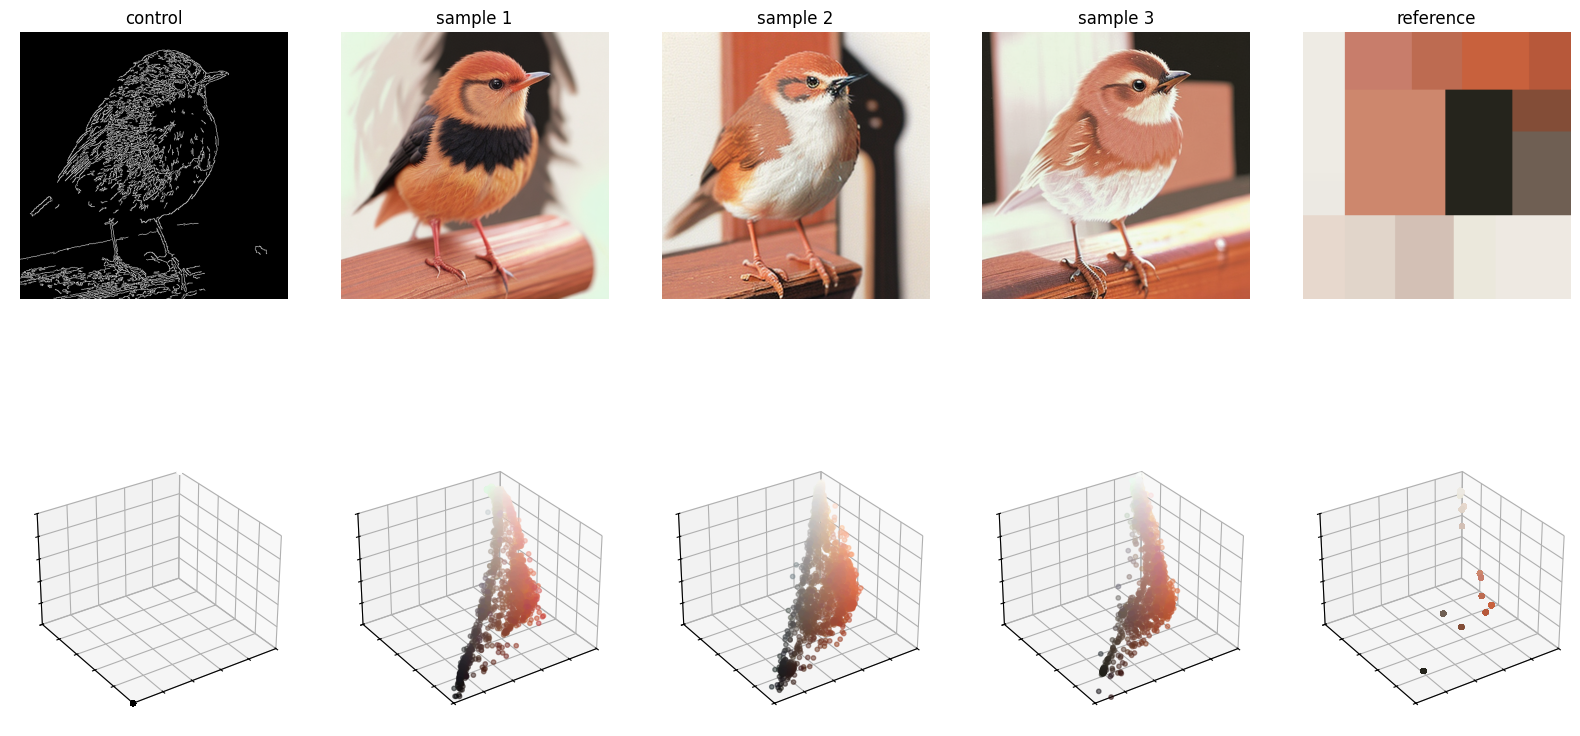

In [5]:
def to_canny_image(pil_image):
    low_threshold = 100
    high_threshold = 200
    image = np.array(pil_image)
    image = cv2.Canny(image, low_threshold, high_threshold)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    return Image.fromarray(image)
    

control_image = Image.open("./assets/controlnet_bird.png")
control_image = control_image.resize((512, 512))
control_image = to_canny_image(control_image)

reference = Image.open("./assets/orange_red.png")
reference = reference.resize((512, 512)).convert('RGB')

out_images = [control_image, ]
for i in range(3):
    out_image = pipe(
        prompt="",
        guess_mode=True,
        image=control_image,
        controlnet_conditioning_scale=1.0,
        guidance_scale=5,
        # --------------------
        num_inference_steps=20, #26
        num_guided_steps=20,    #26
        sw_u_lr=0.013 * 10**4,
        sw_steps=8,
        sw_num_slices=8,
        sw_reference=reference,
    )[0]
    out_images.append(out_image)
out_images.append(reference)

titles = ["control", "sample 1", "sample 2", "sample 3", "reference"]
print_images(out_images, with_density=True, titles = titles, points=3000);

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

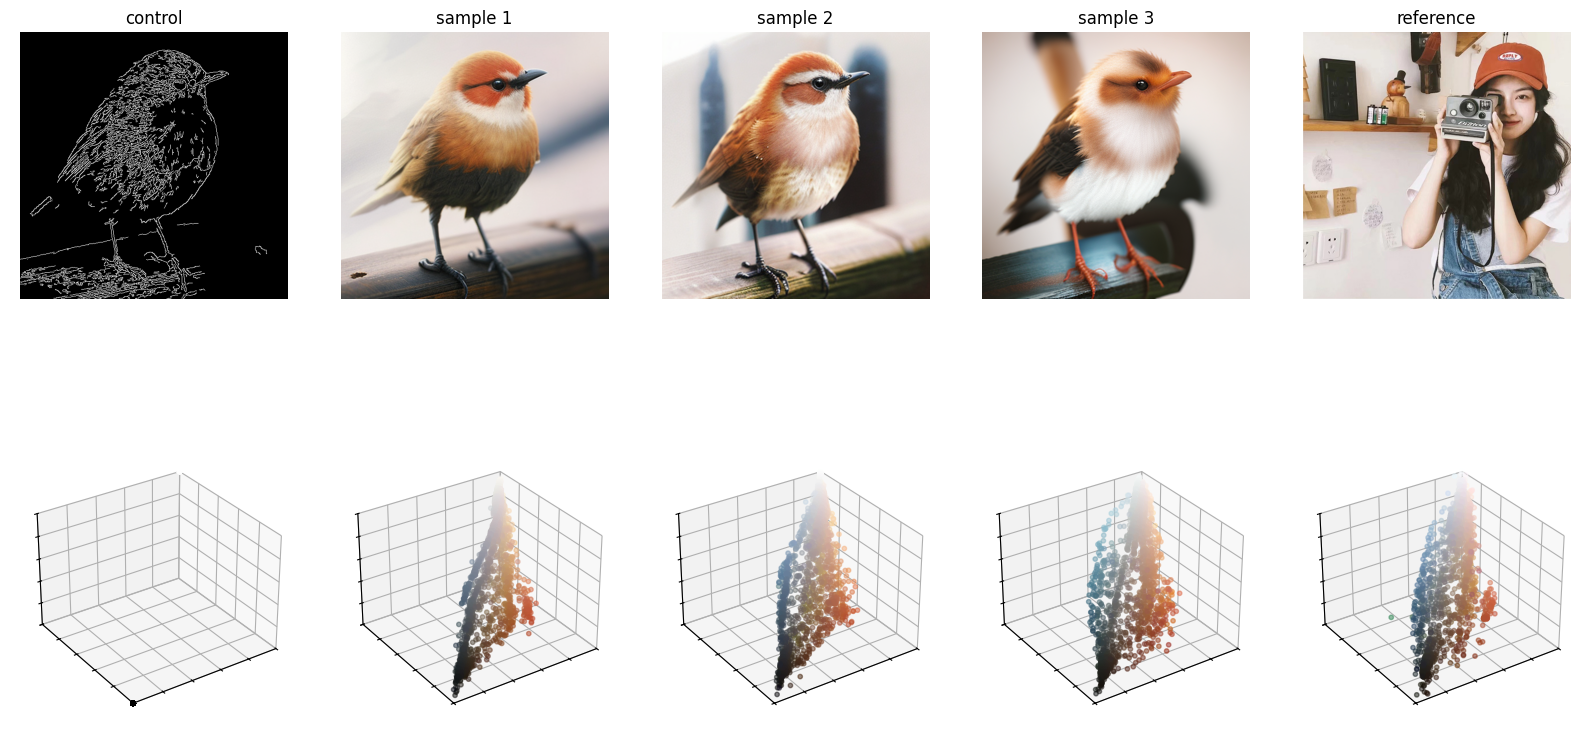

In [6]:
reference = Image.open("./assets/2.jpg")
reference = reference.resize((512, 512)).convert('RGB')

out_images = [control_image, ]
for i in range(3):
    out_image = pipe(
        prompt="",
        guess_mode=True,
        image=control_image,
        controlnet_conditioning_scale=1.0,
        guidance_scale=5,
        # --------------------
        num_inference_steps=26, 
        num_guided_steps=26,
        sw_u_lr=0.015 * 10**4,
        sw_steps=8,
        sw_num_slices=10,
        sw_reference=reference,
    )[0]
    out_images.append(out_image)
out_images.append(reference)

titles = ["control", "sample 1", "sample 2", "sample 3", "reference"]
print_images(out_images, with_density=True, titles = titles, points=3000);

In [7]:
# before running the section below:
del pipe
del controlnet

# Depth ControlNet

In [8]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-depth",
                                             torch_dtype=torch.bfloat16,
                                             use_safetensors=True
                                            ).to(device)

pipe = SwControlNetPipeline.from_pretrained("lykon/dreamshaper-8",
                                            controlnet=controlnet, 
                                            torch_dtype=torch.bfloat16,
                                            use_safetensors=True
                                            ).to(device)

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/alexander/research/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [9]:
control_image = Image.open("./assets/controlnet_vermeer_depth.png")
control_image = control_image.resize((512, 512))

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

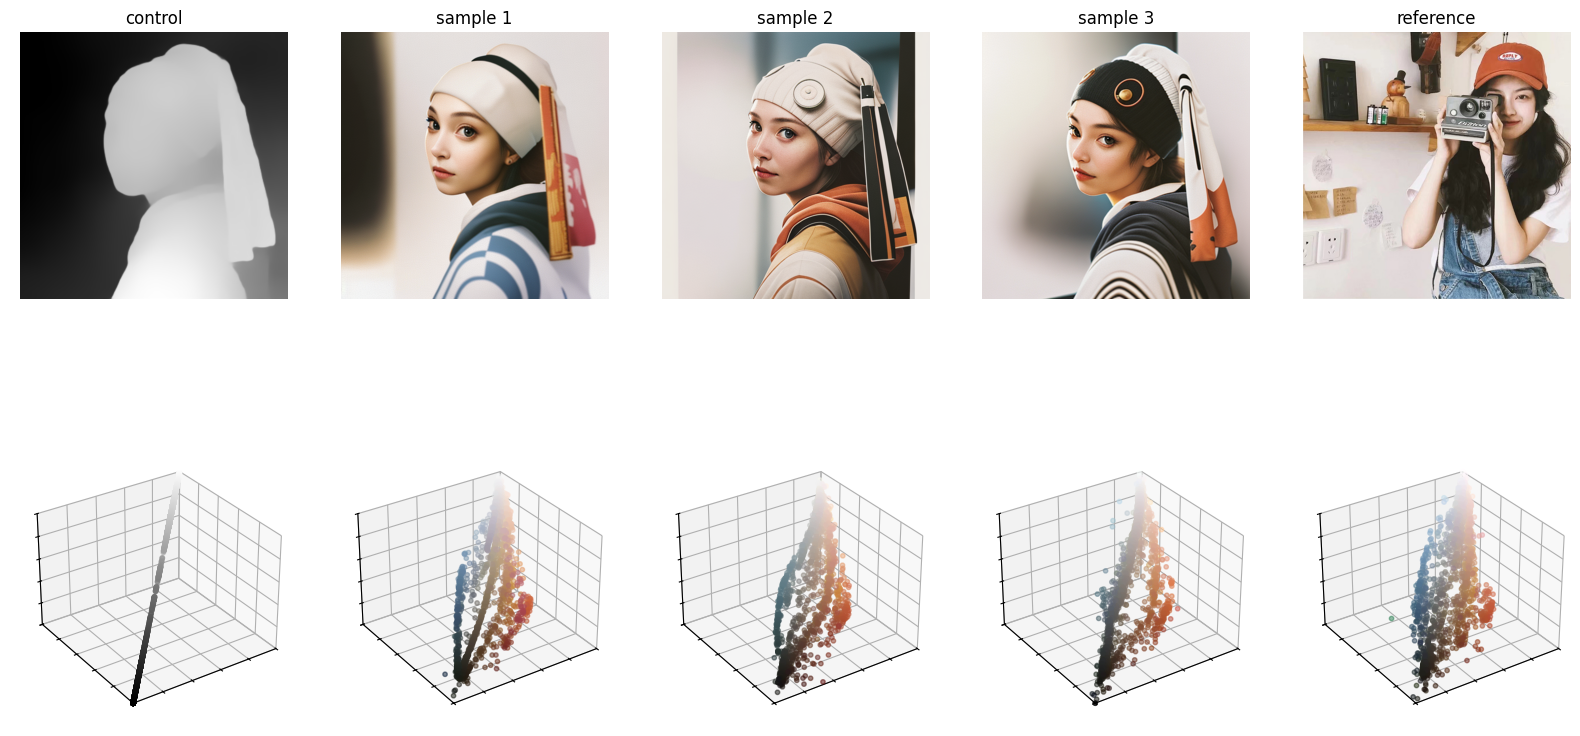

In [10]:
reference = Image.open("./assets/2.jpg")
reference = reference.resize((512, 512)).convert('RGB')

out_images = [control_image, ]
for i in range(3):
    out_image = pipe(
        prompt="portrait of a woman looking into camera",
        guess_mode=True,
        image=control_image,
        controlnet_conditioning_scale=1.5,
        # --------------------
        num_inference_steps=26, 
        num_guided_steps=26,
        sw_u_lr=0.013 * 10**4,
        sw_steps=8,
        sw_num_slices=10,
        sw_reference=reference,
    )[0]
    out_images.append(out_image)
out_images.append(reference)

titles = ["control", "sample 1", "sample 2", "sample 3", "reference"]
print_images(out_images, with_density=True, titles = titles, points=3000);

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

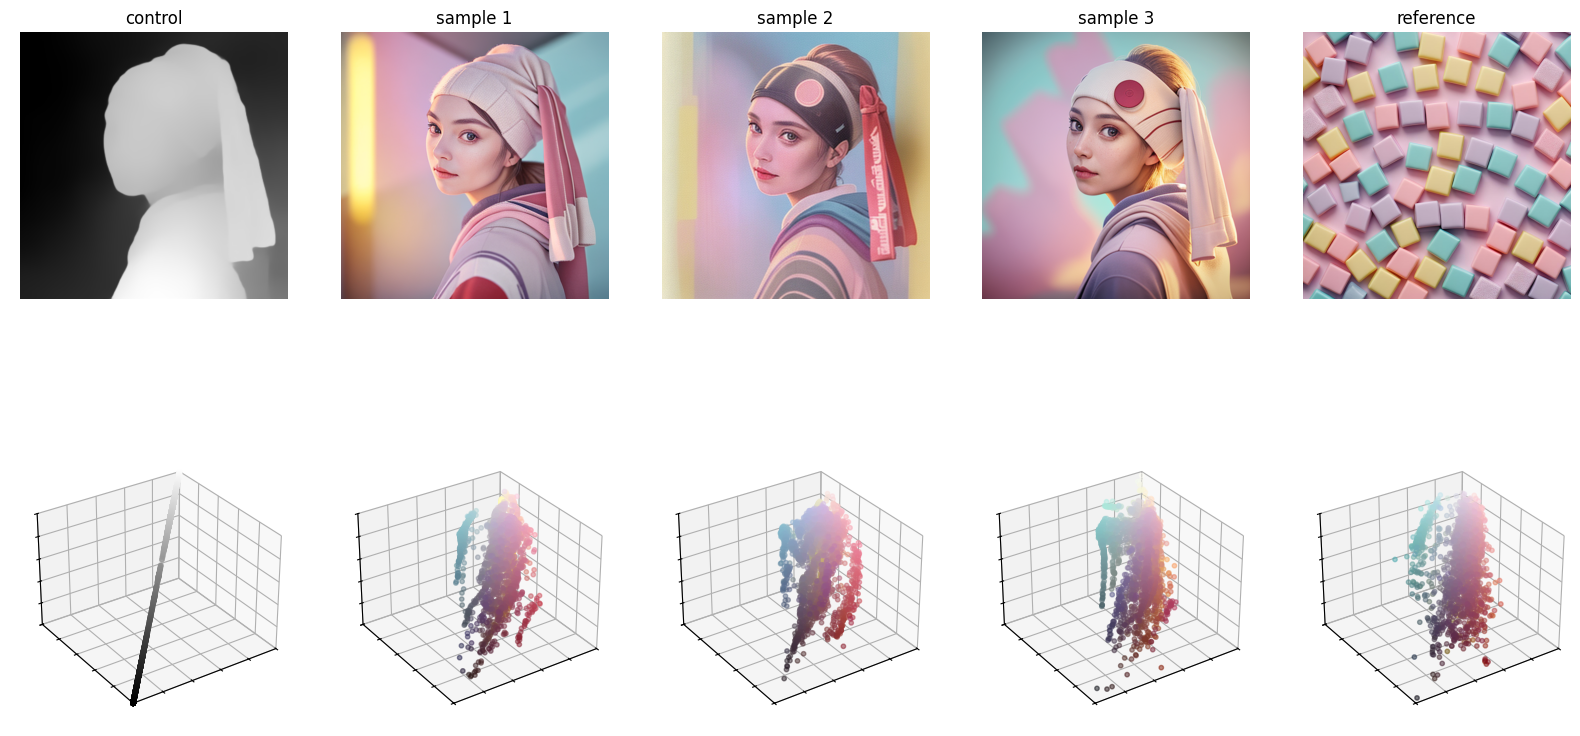

In [11]:
reference = Image.open("./assets/pastel.jpeg")
reference = reference.resize((512, 512)).convert('RGB')

out_images = [control_image, ]
for i in range(3):
    out_image = pipe(
        prompt="portrait of a woman looking into camera",
        guess_mode=True,
        image=control_image,
        controlnet_conditioning_scale=1.5,
        # --------------------
        num_inference_steps=26, 
        num_guided_steps=26,
        sw_u_lr=0.013 * 10**4,
        sw_steps=8,
        sw_num_slices=10,
        sw_reference=reference,
    )[0]
    out_images.append(out_image)
out_images.append(reference)

titles = ["control", "sample 1", "sample 2", "sample 3", "reference"]
print_images(out_images, with_density=True, titles = titles, points=3000);